# Mitani's calculation of synchrony

In [6]:
males = 10
females = 10
mating_season_length = 100
IBI = 1
POP_length = 5
cycles_to_conception = 3

(males * IBI * mating_season_length) / (females * POP_length * cycles_to_conception)

13.333333333333334

# Imports

In [8]:
import random as rd
import os
import math
from math import sqrt
import statistics
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from numpy.random import choice
from numpy.random import uniform
from numpy.random import normal
from numpy.random import randint
from numpy.random import permutation
from numpy import corrcoef
from numpy import flip
from numpy import around
from numpy import array as nparray
from numpy import arange as arange
from random import choices as rdchoices
from random import uniform as rduniform
import numba as nb
import time
import scipy.stats
from scipy.stats import multivariate_normal as mvn
from sklearn.utils import shuffle
import statistics
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot as plot
from matplotlib.pyplot import figure as figure
from collections import Counter
from scipy.stats import skewnorm
from itertools import chain
import cProfile, pstats
from tqdm import tqdm
import seaborn as sns
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf

/Users/kevinrosenfield/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Class definitions

## Female

In [2]:
# an object of the class 'male' represents a single male; 'male' objects are indexed in the 'males'
# list contained in 'group' objects

class female:

    def __init__(self, f, parentGroup, gen, genes=[0, 0, 0, 0]):

        self.ID = f
        self.status, self.cycleDay = "nonCycling", False
        self.conceptionProbability, myConceptionProbabilityList = 0, []
        self.nonCyclingLength = randint(rangeOfNonCyclingDays + 1)
        self.daysUntilCycling = self.nonCyclingLength
        self.daysUntilConception = False
        self.myConceptionProbabilityList = []
        self.genes = genes
        self.reproductiveSuccess = 0
        self.cost = 0
        self.uniqueID = str(gen) + '-' + str(parentGroup) + str(self.ID)

    def switchToCycling(self):

        self.cycleDay = 0
        self.status = "cycling"
        self.cyclingLength = abs(
            round(normal(meanDaysToConception, sdDaysToConception)))
        self.daysUntilConception = self.cyclingLength
        self.conceptionProbability = conceptionProbabilityList[0]

    def switchToDone(self):

        self.cycleDay = False
        self.status = "done"

## Male

In [3]:
# an object of the class 'male' represents a single male; 'male' objects are indexed in the 'males'
# list contained in 'group' objects

class male:
    
    def __init__(self, m, parentGroup,gen,genes=[0,0,0,0]):
        
        self.noise = (1 - qualityHeritability )/ qualityHeritability
        self.ID = m
        self.genes = genes
        #self.quality = (((self.genes[0] + self.genes[1])/2) + uniform(0,self.noise)) / (1 + self.noise)
        self.qualityMean = ((self.genes[0] + self.genes[1]) / 2)
        self.quality = (self.qualityMean * qualityHeritability) + (uniform(0,1) * (1 - qualityHeritability))
        
        self.competitiveEffort = (self.genes[2] + self.genes[3]) / 2
        self.rank = 0
        self.cost = 0
        self.reproductiveSuccess = 0
        self.matings = 0
        self.uniqueID = str(gen) + '-' + str(parentGroup)+ str(self.ID)

In [3]:
#varList2 = []
genVar = [i/1000 for i in range(0,501)]
for v in genVar:
    qualityGenes = uniform(0.5-v,0.5+v,100000)
    qualityNoise = uniform(-0.5 + v, 0.5 - v, 100000)
    actualQuality = [qualityGenes[i] + qualityNoise[i] for i in range(len(qualityGenes))]
    heritability.append(statistics.variance([q for q in qualityGenes]) / statistics.variance([q for q in actualQuality]))

heritability = {(1-i)/2:j for i,j in zip(genVar, heritability)}


NameError: name 'heritability' is not defined

In [164]:
heritability2

{0.0: 0.033,
 0.01: 0.054,
 0.02: 0.069,
 0.03: 0.079,
 0.04: 0.088,
 0.05: 0.097,
 0.06: 0.104,
 0.07: 0.11,
 0.08: 0.116,
 0.09: 0.122,
 0.1: 0.127,
 0.11: 0.132,
 0.12: 0.137,
 0.13: 0.141,
 0.14: 0.146,
 0.15: 0.149,
 0.16: 0.154,
 0.17: 0.157,
 0.18: 0.161,
 0.19: 0.164,
 0.2: 0.168,
 0.21: 0.172,
 0.22: 0.174,
 0.23: 0.178,
 0.24: 0.181,
 0.25: 0.184,
 0.26: 0.187,
 0.27: 0.19,
 0.28: 0.193,
 0.29: 0.196,
 0.3: 0.199,
 0.31: 0.201,
 0.32: 0.204,
 0.33: 0.206,
 0.34: 0.21,
 0.35: 0.212,
 0.36: 0.215,
 0.37: 0.218,
 0.38: 0.22,
 0.39: 0.223,
 0.4: 0.226,
 0.41: 0.228,
 0.42: 0.23,
 0.43: 0.232,
 0.44: 0.235,
 0.45: 0.239,
 0.46: 0.241,
 0.47: 0.244,
 0.48: 0.246,
 0.49: 0.248,
 0.5: 0.25,
 0.51: 0.253,
 0.52: 0.256,
 0.53: 0.258,
 0.54: 0.261,
 0.55: 0.263,
 0.56: 0.265,
 0.57: 0.268,
 0.58: 0.271,
 0.59: 0.274,
 0.6: 0.276,
 0.61: 0.278,
 0.62: 0.282,
 0.63: 0.283,
 0.64: 0.286,
 0.65: 0.29,
 0.66: 0.292,
 0.67: 0.295,
 0.68: 0.296,
 0.69: 0.3,
 0.7: 0.304,
 0.71: 0.307,
 0.72: 0.

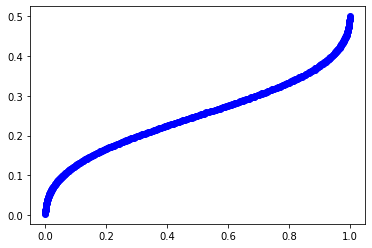

In [156]:
plt.plot([*heritability2.keys()], [*heritability2.values()], 'bo')

In [232]:
N = 10
K = 1
M = 2
S = [2, 6]

def getMaxAdditionalDinersCount(N: int, K: int, M: int, S: List[int]) -> int:
    s_list = [0] * N

    for s in S:
        s_list[s] = 1
        
    consecutive_empty = 1
    additional_guests = 0
    
    for s in s_list:
        if s == 0:
            consecutive_empty += 1
        elif consecutive_empty >= K * 3:
            additional_guests += math.floor(consecutive_empty / (K * 3))
            consecutive_empty = 0
        else:
            consecutive_empty = 0
    
    if consecutive_empty >= K + 1:
        additional_guests += math.floor((consecutive_empty + 1) / (K * 3))
        
    return additional_guests


[2, 2, 1, 0, 0, 0, 1, 0, 0, 0]

## Group

In [4]:
# an object of the class 'group' represents a single group of primates; 'group'
# objects are indexed in the 'groups' list contained in 'population' objects

class group:

    # when a 'group' object is initialized, 'male' and 'female' objects are automatically instantiated in lists
    # ('males' and 'females') contained in the 'group' object
    # the male dominance hierarchy is set when the 'setRanks' method runs during 'group' initialization

    
    def __init__(self, g, gen):

        self.ID = g
        self.females = [
            female(f, self.ID, gen, genes=uniform(0, 1, 4))
            for f in range(nFemales)
        ]
        self.males = [
            male(m, self.ID, gen, genes=uniform(0, 1, 4))
            for m in range(nMales)
        ]
        self.modelDays = 0
        self.setRanks()
        self.actualRankQualityCorrelation = corrcoef(
            [nMales - m.rank for m in self.males],
            [np.mean([m.genes[0], m.genes[1]]) for m in self.males])[1, 0]

    # the method 'go' of class 'group' carries out a simulation of daily mating competition until all 'female'
    # objects have conceived (their 'status' attribute has switched from 'cycling' to 'nonCycling')

    def go(self):

        [initialData(self.ID, m) for m in self.males]
        self.males = sorted(self.males, key=self.sortRank)

        for r in range(10000):
            self.modelDays += 1
            if all([item.status == "done" for item in self.females]):
                break

            #self.females = sorted(self.females, key=self.sortConceptionProbability, reverse = True)

            self.females = permutation(self.females)
            self.females = sorted(self.females,
                                  key=self.sortStatus,
                                  reverse=False)

            self.conceptionProbabilities = [
                f.conceptionProbability for f in self.females
            ]

            self.makeMatingPairs() if any(self.conceptionProbabilities) else 0

            for f in [
                    item for item in self.females if item.status == "cycling"
            ]:
                f.daysUntilConception -= 1
                f.cycleDay = f.cycleDay + 1 if f.cycleDay < cycleLength - 1 else 0
                f.conceptionProbability = conceptionProbabilityList[f.cycleDay]
                f.myConceptionProbabilityList += [
                    conceptionProbabilityList[f.cycleDay]
                ]
                f.switchToDone() if f.daysUntilConception <= 0 else 0

            for f in [
                    item for item in self.females
                    if item.status == "nonCycling"
            ]:
                f.daysUntilCycling -= 1
                f.myConceptionProbabilityList += [0]
                f.switchToCycling() if f.daysUntilCycling <= 0 else 0

            for f in [item for item in self.females if item.status == "done"]:
                f.myConceptionProbabilityList += [0]

        self.p = [m.reproductiveSuccess for m in self.males]

        if self.ID == 0:
            model.listOfRSCorrels += [
                corrcoef([nMales - m.rank for m in self.males],
                         [m.reproductiveSuccess for m in self.males])[1, 0]
            ]
            model.listOfQualityRSCorrels += [
                corrcoef([m.quality for m in self.males],
                         [m.reproductiveSuccess for m in self.males])[1, 0]
            ]

    def sortQuality(self, m):
        return m.quality

    def sortRank(self, m):
        return m.rank

    def sortConceptionProbability(self, f):
        return f.conceptionProbability + uniform(0.0001)

    def sortStatus(self, f):
        return f.status

    def setRanks(self):

        # empty list for each males' number of entries
        self.maleRankEntries = []

        # for each male, his entries correspond to his quality * 100 if his competitiveEffortis above threshold,
        # otherwise, his number of entries is random
        # also, add his number of entries to the list of entries
        for m in self.males:
            #self.entries = m.quality if uniform(0,1) < m.competitiveEffort else uniform(0,1) #abs(normal(0.0,0.334))
            self.entries = (m.quality * m.competitiveEffort)**4
            self.maleRankEntries += [self.entries + 0.0000000001]

        # scale males' number of entries so that proportions are the same but they sum to 1 (necessary for next step)
        self.maleRankEntries = [
            e / sum(self.maleRankEntries) for e in self.maleRankEntries
        ]

        # select males one by on based on their proportional size in entries list (p parameter takes list of weights)
        self.males = choice(self.males,
                            p=self.maleRankEntries,
                            size=nMales,
                            replace=False)

        for i, m in enumerate(self.males):
            m.rank = i
            m.cost = m.competitiveEffort

    def makeMatingPairs(self):

        nPairs = len(
            [item for item in self.females if item.status == "cycling"])
        for m, f in zip(self.males[:nPairs], self.females[:nPairs]):

            m.reproductiveSuccess += f.conceptionProbability  # * m.quality**(1/10)
            f.reproductiveSuccess += f.conceptionProbability  # * m.quality**(1/10)
            m.matings += 1

            addToDataFile(self.ID, m, f)

    def setupNextGen(self):

        self.nextGenMotherGenes = []
        motherProbabilities = [f.reproductiveSuccess for f in self.females]
        # lack of ability to chose becomes a cost as competitiveEffort goes down

        self.nextGenFatherGenes = []
        fatherProbabilities = np.array([
            m.reproductiveSuccess - m.cost for m in self.males
        ])  # does male quality matter?
        #fatherProbabilities[fatherProbabilities < 0] = 0

        parentsStartingPoint = model.generation * model.nAgents

        moms = [
            rdchoices(model.potentialMoms[parentsStartingPoint +
                                          i:parentsStartingPoint + i + 2],
                      weights=[
                          motherProbabilities[p]
                          for p in model.potentialMoms[parentsStartingPoint +
                                                       i:parentsStartingPoint +
                                                       i + 2]
                      ],
                      k=1)[0] for i in np.arange(0, (model.nAgents * 2), 2)
        ]
        dads = [
            rdchoices(model.potentialDads[parentsStartingPoint +
                                          i:parentsStartingPoint + i + 2],
                      weights=[
                          fatherProbabilities[p]
                          for p in model.potentialDads[parentsStartingPoint +
                                                       i:parentsStartingPoint +
                                                       i + 2]
                      ],
                      k=1)[0] for i in np.arange(0, (model.nAgents * 2), 2)
        ]

        self.nextGenMotherGenes = [self.females[m].genes.copy() for m in moms]
        self.nextGenFatherGenes = [self.males[d].genes.copy() for d in dads]


#     def recombination(self):

#         self.offspringGenes = []
#         recombinationPoints = choice(range(model.numberGenes), model.nAgents)
#         splitTypes = randint(0,2, model.nAgents)
#         i = 0
#         while i < model.nAgents:
#             recombinationPoint = recombinationPoints[i]
#             if splitTypes[i] == 1:
#                 self.offspringGenes.append([m for m in self.nextGenMotherGenes[i][:recombinationPoint]] +
#                                            [f for f in self.nextGenFatherGenes[i][recombinationPoint:]])
#             else:
#                 self.offspringGenes.append([f for f in self.nextGenFatherGenes[i][:recombinationPoint]] +
#                                            [m for m in self.nextGenMotherGenes[i][recombinationPoint:]])
#             i += 1

    def recombination(self):

        self.offspringGenes = []
        splitTypes = randint(0, 2, model.nAgents)
        i = 0
        while i < model.nAgents:
            if splitTypes[i] == 1:
                self.offspringGenes.append(self.nextGenMotherGenes[i])
            else:
                self.offspringGenes.append(self.nextGenFatherGenes[i])
            i += 1

    def mutation(self):

        genesInGroup = model.nAgents
        mutations = model.mutations[model.generation - 1]

        offspringsMutating = choice(range(model.nAgents),
                                    mutations,
                                    replace=False)

        genesMutating = choice([0, 1, 2, 3], mutations)
        pertubations = uniform(-0.04, 0.04, mutations)

        newGenes = nparray([
            self.offspringGenes[offspringsMutating[m]][genesMutating[m]] +
            pertubations[m] for m in range(mutations)
        ])

        newGenes[newGenes < 0] = 0

        for m in range(mutations):
            self.offspringGenes[offspringsMutating[m]][
                genesMutating[m]] = newGenes[m]

    def scaleQuality(self):

        for gene in [0, 1]:
            qualityDict = {
                g: self.offspringGenes[g][gene] + uniform(-0.00001, 0.00001)
                for g in range(model.nAgents)
            }

            qualityList = [v for k, v in qualityDict.items()]
            #qualityList = (qualityList - np.min(qualityList))/np.ptp(qualityList)
            qualityList = [q / max(qualityList) for q in qualityList]

            for g in range(model.nAgents):
                self.offspringGenes[g][gene] = qualityList[g]

    def reset(self):

        self.modelDays = 0
        self.males, self.females = [], []
        self.males = [
            male(m,
                 self.ID,
                 model.generation,
                 genes=self.offspringGenes[m + nFemales])
            for m in range(nMales)
        ]
        self.females = [
            female(f, self.ID, model.generation, genes=self.offspringGenes[f])
            for f in range(nFemales)
        ]
        self.setRanks()
        self.actualRankQualityCorrelation = corrcoef(
            [nMales - m.rank for m in self.males],
            [m.quality for m in self.males])[1, 0]

cycleLength = 28
ovulation = 16
pre = ovulation - 6
post = cycleLength - pre - 6
conceptionProbabilityList = [0] * pre + [
    .05784435, .16082819, .19820558, .25408223, .24362408, .10373275
] + [0] * post

## Population

In [5]:
class population:
    
    def __init__(self):
        
        self.listOfQualityCorrels = []
        self.listOfRSCorrels = []
        self.listOfQualityRSCorrels = []
        self.generation = 1
        self.numberGenes = 2
        self.rangeFemales = range(nFemales)
        self.rangeMales = range(nMales)
        self.nAgents = nMales + nFemales
        self.totalAgents = nGroups * self.nAgents
        self.rangeGroups = range(nGroups)
        self.mutations = [round(uniform(0,self.nAgents * mutationRate * 2)) for i in range(nGenerations * nGroups)]
        self.potentialMoms = rdchoices(range(nFemales), k = 3 * self.nAgents * nGenerations * nGroups)
        self.potentialDads = rdchoices(range(nMales), k = 3 * self.nAgents * nGenerations * nGroups)
        self.groups = [group(g,self.generation) for g in self.rangeGroups]
        self.modelID = str(time.time())[3:9]        
    
    def evolve(self):

        %matplotlib qt

        model.matingStats = []
        
        for gen in tqdm(range(nGenerations)):

            self.listOfQualityCorrels += [corrcoef([nMales-m.rank for m in self.groups[0].males],[m.quality for m in self.groups[0].males])[1,0]]

            for group in self.groups:
                group.go()
            
                rankList = [nMales-m.rank for m in self.groups[0].males] if self.generation == nGenerations else 0
                
                self.geneticAlgorithm(group)
                
            
            self.plotRankQuality() if uniform(0,1) > 0.8 and realTimePlots else 0
        
        c=['Model ID','Seasonality','Number of Males', 'Number of Females','Mutation Rate',
           'Migration Rate', 'Heritability of Quality','Generation','ModelDay','Group','Male Unique ID',
           'Rank','QualityGene1','QualityGene2','CompeteGene1','CompeteGene2','Rank-Quality Correlation',
           'Male Reproductive Success','Female Unique ID','Female Conception Probability',
           'Female Reproductive Success','Male Number Matings']

        model.matingStats=pd.DataFrame(model.matingStats,columns=c)

        model.matingStats.to_csv('matingData.csv', mode='a', header=False, index=False)    
                
        %matplotlib inline
        plt.plot(rankList, self.groups[0].p)        
        
    def geneticAlgorithm(self,group=group):
        
        group.setupNextGen()
        
        group.recombination()
        
        group.mutation() if model.mutations[model.generation - 1] > 0 else 0
        
        group.scaleQuality()
        
        self.generation += 1
        
        group.reset()
                
        self.migration() if dispersal else 0
        
    def migration(self):
                
        migrations = round(uniform(self.totalAgents * migrationRate * 2))
        groupsLeavingFrom = choice([g for g in self.groups], migrations)
        agentsLeaving = choice(range(nMales), migrations)
        
        for m in range(migrations):
            
            groupLeavingFrom = groupsLeavingFrom[m]
            
            if rd.uniform(0,1) > maleDispersalBias:
                agentLeaving = groupLeavingFrom.males[agentsLeaving[m]]
                agentComing = rd.choice(rd.choice([g for g in self.groups if g != groupLeavingFrom]).males)
            else:
                agentLeaving = groupLeavingFrom.females[agentsLeaving[m]]
                agentComing = rd.choice(rd.choice([g for g in self.groups if g != groupLeavingFrom]).females)
            
            tempGenes, tempCost = agentLeaving.genes, agentLeaving.cost
            agentLeaving.genes, agentLeaving.cost = agentComing.genes, agentComing.cost
            agentComing.genes, agentComing.cost = tempGenes, tempCost

    def plotRankQuality(self):
        
        
        plt.clf()
        plt.plot([np.mean([m.genes[0],m.genes[1]]) for m in self.groups[0].males], [nMales-m.rank for m in self.groups[0].males], 'bo')
        plt.text(0.1, nMales*0.8,
             str(round(corrcoef([nMales-m.rank
                                  for m
                                  in self.groups[0].males],[np.mean([m.genes[0],m.genes[1]])
                                                            for m
                                                            in self.groups[0].males])[1,0],2)))
        plt.xlim([0,1.2])
        plt.ylim([0,nMales*1.2])
        plt.pause(0.00001)
        plt.show()

        

Create .csv file containing data

In [6]:
def newDataFile():

    c = [
        'Model ID', 'Seasonality', 'Number of Males', 'Number of Females',
        'Mutation Rate', 'Migration Rate', 'Heritability of Quality',
        'Generation', 'ModelDay', 'Group', 'Male Unique ID', 'Rank',
        'QualityGene1', 'QualityGene2', 'CompeteGene1', 'CompeteGene2',
        'Rank-Quality Correlation', 'Male Reproductive Success',
        'Female Unique ID', 'Female Conception Probability',
        'Female Reproductive Success', 'Male Number Matings'
    ]

    matingStats = pd.DataFrame(columns=c)

    matingStats.to_csv('matingData.csv', index=False)


def initialData(gr, m):
    model.matingStats.append([
        model.modelID, seasonality, nMales, nFemales, mutationRate,
        migrationRate, qualityHeritability, model.generation,
        model.groups[gr].modelDays, model.groups[gr].ID, m.uniqueID, m.rank,
        m.genes[0], m.genes[1], m.genes[2], m.genes[3],
        model.groups[gr].actualRankQualityCorrelation, 0, 'NA', 0, 0, 0
    ])


def addToDataFile(gr, m, f):
    model.matingStats.append([
        model.modelID, seasonality, nMales, nFemales, mutationRate,
        migrationRate, qualityHeritability, model.generation,
        model.groups[gr].modelDays, model.groups[gr].ID, m.uniqueID, m.rank,
        m.genes[0], m.genes[1], m.genes[2], m.genes[3],
        model.groups[gr].actualRankQualityCorrelation, m.reproductiveSuccess,
        f.uniqueID, f.conceptionProbability, f.reproductiveSuccess, m.matings
    ])

In [90]:
model.groups[0].scaleQuality()



# Model tests

100%|██████████| 5000/5000 [03:34<00:00, 23.33it/s] 


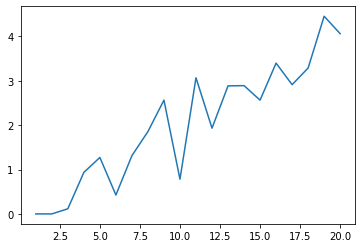

In [8]:
nGenerations = 5000
mutationRate = 0.01

dispersal = True
migrationRate = 0.01
maleDispersalBias = 0.5

qualityHeritability = 0.5
startingCorrel = 0.5

nFemales = 20
nMales = 20
nGroups = 5

seasonality = 0.0
rangeOfNonCyclingDays = 365 - (365 * seasonality)
realTimePlots = False

meanDaysToConception = 60
sdDaysToConception = 0# * (1.0 - seasonality)

newDataFile()
seasonality = 0.2
rangeOfNonCyclingDays = 365 - (365 * seasonality)
model = population()
model.evolve()

seasonality = 0.5
rangeOfNonCyclingDays = 365 - (365 * seasonality)
model = population()
model.evolve()

seasonality = 0.8
rangeOfNonCyclingDays = 365 - (365 * seasonality)
model = population()
model.evolve()

# palette = np.flip(sns.color_palette("viridis",100))

# fig,ax = plt.subplots(figsize=[12,12])
# plt.title("Correlations Between Rank and Quality Over Time", size = 20)
# plt.xlabel("Generation", size = 17)
# plt.ylabel("Correlation", size = 17)


# for i,s in enumerate([0.0,0.2,0.4,0.6,0.8,1.0]):
#     seasonality = s
#     meanDaysToConception = 60
#     sdDaysToConception = 50 * (1.0 - seasonality)
    
#     rangeOfNonCyclingDays = 365 - (365 * seasonality)

#     model = population()
#     model.evolve()

#     listOfQualityCorrels_split = np.array_split(model.listOfQualityCorrels,10)
#     ax.plot([np.nanmean(j) for j in listOfQualityCorrels_split],color=palette[i*12], linewidth=3,label=s)
#     ax.legend(loc='best')
#     plt.close()
    

In [ ]:
cols = ["Quality", "GeneQual","Correl","Rank","RS","Matings","Cost", "RS - Cost",
        "QualGene1","QualGene2","Noise","CorrGene1","CorrGene2"]
IDs = [m.ID for m in model.groups[0].males]

df = pd.DataFrame(
    [
        [m.quality, (m.genes[0]+m.genes[1])/2,m.competitiveEffort, m.rank, m.reproductiveSuccess,
         m.matings/model.groups[0].modelDays,m.cost,m.reproductiveSuccess-m.cost, m.genes[0],m.genes[1],m.noise,m.genes[2],m.genes[3]
        ] for i,m in enumerate(model.groups[0].males)
    ], columns=cols,index=IDs).round(3).sort_values(by="Rank", ascending=True)

pd.set_option('display.max_rows', df.shape[0]+1)
df

# Exploratory data anlysis

In [56]:
def synchronyCharts(group):
    
    plt.figure(figsize=(20, 9))
    allDays = plt.scatter([range(group.modelDays)] * nFemales, [[f.myConceptionProbabilityList[i] + f.ID
                                        for i in range(group.modelDays)]
                                       for f in group.females], s=8)

    totalProb = [0] * group.modelDays

    for i in range(group.modelDays):
        totalProb[i] =  sum([f.myConceptionProbabilityList[i] for f in group.females]) - 2
    
    textList = [0] * group.modelDays
    for i in range(group.modelDays):
        textList[i] = sum([f.myConceptionProbabilityList[i] > 0 for f in group.females])
        
    linesList = [0] * group.modelDays
    for i in range(group.modelDays):
        #if sum([f.myConceptionProbabilityList[i] > 0 for f in g.females]) > 1:
        linesList[i] = sum(
            [f.myConceptionProbabilityList[i]
             for f in group.females]) if sum([f.myConceptionProbabilityList[i] > 0
                                                                           for f in group.females]) > 1 else 0
    allDaysTotal = plt.scatter([range(group.modelDays)], totalProb)
    
    scalingLinesList = nFemales/max(textList)
    linesList = (linesList - np.min(linesList))/np.ptp(linesList)
    linesList = [l/scalingLinesList for l in linesList]
    
#     plt.vlines(x=range(group.modelDays), ymin=0, ymax=nFemales+1,
#                colors=([(0.99,0,0,l) for l in linesList]), lw=[(l>0)*3 for l in linesList])
#     plt.vlines(x=range(group.modelDays), ymin=0, ymax=nFemales+1,
#                colors=(0.0,0,0.99,0.99), lw=[(l==0) for l in linesList])
    
    j = 0
    lastNum,up = 0,False
    for i, num in enumerate(textList):
        if lastNum > 1 and num > 1 and up==False:
            j,up = nFemales/10,True
        else:
            j,up = 0,False
        plt.annotate(num, (i, nFemales + 1.5 + j),size=16) if num > 1 else 0
        lastNum = num

    plt.ylim([-3,nFemales + 8])
    
    figure(figsize=[20,5])

    dailyCyclingFemales = [day
                           for days in [[i for i in range(f.nonCyclingLength,f.nonCyclingLength+f.cyclingLength)]
                                        for f in group.females] for day in days]

    numOfCyclingFemalesByDay = [dailyCyclingFemales.count(num) for num in range(group.modelDays)]

    plt.bar(range(group.modelDays),numOfCyclingFemalesByDay)
    
    plt.ylim([0,nFemales*1.1])
    
    groupConceptionProbabilities = []
    lenFertilePerDay = group.modelDays
    
    for d in range(group.modelDays):
        groupConceptionProbabilities += [sum([0 if f.myConceptionProbabilityList[d] == False else 1
                                              for f in group.females])]

    fertilePerDay = [groupConceptionProbabilities.count(i) / group.modelDays for i in range(nFemales + 1)]

    for day in np.flip(range(len(fertilePerDay))):
        if fertilePerDay[day] ==  0:
            fertilePerDay.pop(day)
        else:
            break

    t = 0
    for i in range(len(fertilePerDay)):
        t += (groupConceptionProbabilities.count(i) / group.modelDays)
        fertilePerDay += [t]


    d = pd.DataFrame([[round(f*cycleLength,1) for f in fertilePerDay],
                      [f for f in range(round(len(fertilePerDay)/2))]*2,
                      ["day" for f in range(round(len(fertilePerDay)/2))] +
                      ["cumulative" for f in range(round(len(fertilePerDay)/2))]],
                     index=["numberFertile", "day", "category"]).T

    plt.figure(figsize=(18, 5))
    fertilePerDayPlot = sns.barplot("day", "numberFertile", data = d, hue = 'category')

    plt.bar_label(fertilePerDayPlot.containers[0], size = 13)
    plt.bar_label(fertilePerDayPlot.containers[1], size = 13)
    xlabel = plt.xlabel('Number of females in POP', size=25)
    ylabel = plt.ylabel('Average number of days per cycle', size=25)
    ylim = plt.ylim([0,110])
    

In [58]:

nMales = 20
nFemales = 20

meanDaysToConception = 60
sdDaysToConception = 50 * (1.0 - seasonality)

cycleLength = 28

ovulation = 16
pre = ovulation - 6
post = cycleLength - pre - 6
conceptionProbabilityList = [0] * pre + [.05784435,.16082819,.19820558,.25408223,.24362408,.10373275] + [0] * post



In [55]:
nMales = 10
nFemales = 10

seasonality = 0.9
sdDaysToConception = 50 * (1.0 - seasonality)
rangeOfNonCyclingDays = 365 - (365 * seasonality)

g = group(0)
g.go()

synchronyCharts(g)

print(g.modelDays)

nFemales = 20
nMales = 20

seasonality = 0.7
sdDaysToConception = 0 # 50 * (1.0 - seasonality)
rangeOfNonCyclingDays = 365 - (365 * seasonality)

g = group(0)
# g.females[0].daysUntilCycling,g.females[1].daysUntilCycling,g.females[2].daysUntilCycling = 17,144,192
# g.females[0].nonCyclingLength,g.females[1].nonCyclingLength,g.females[2].nonCyclingLength = 17,144,192
g.go()

synchronyCharts(g)

print(g.modelDays)

NameError: name 'synchronyCharts' is not defined

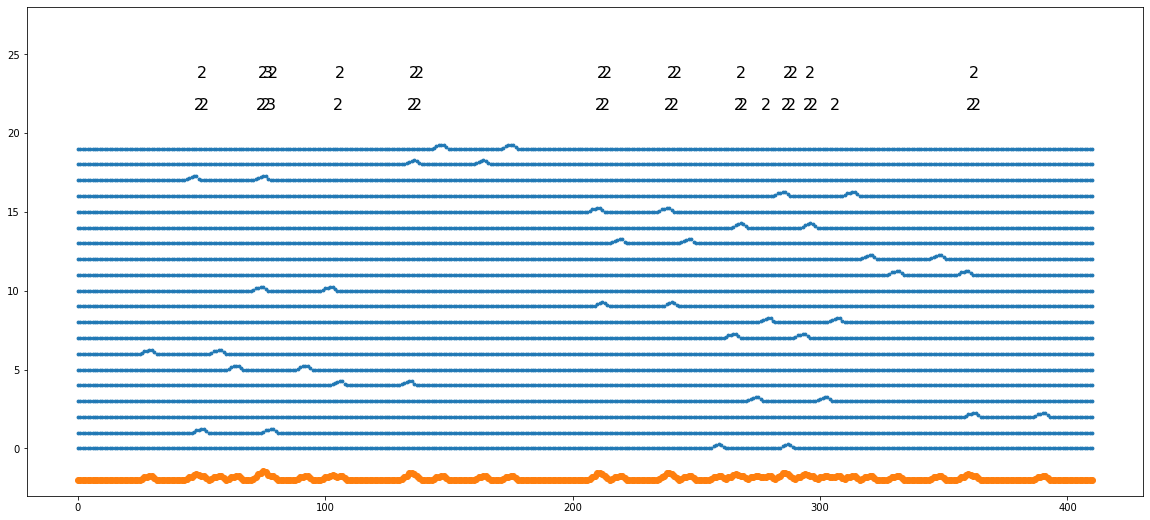

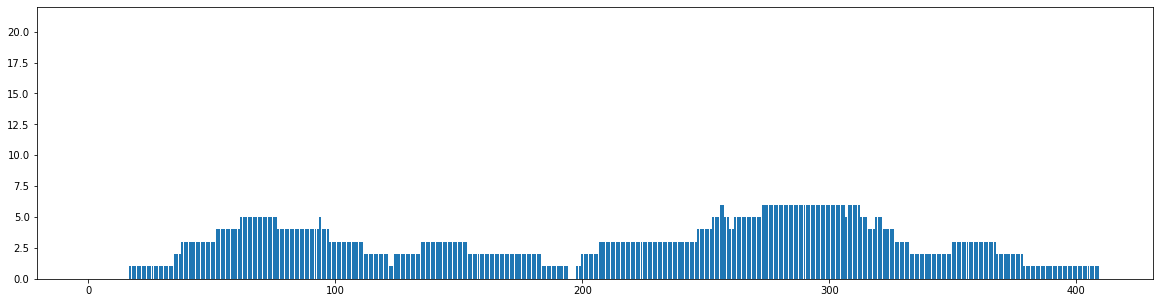

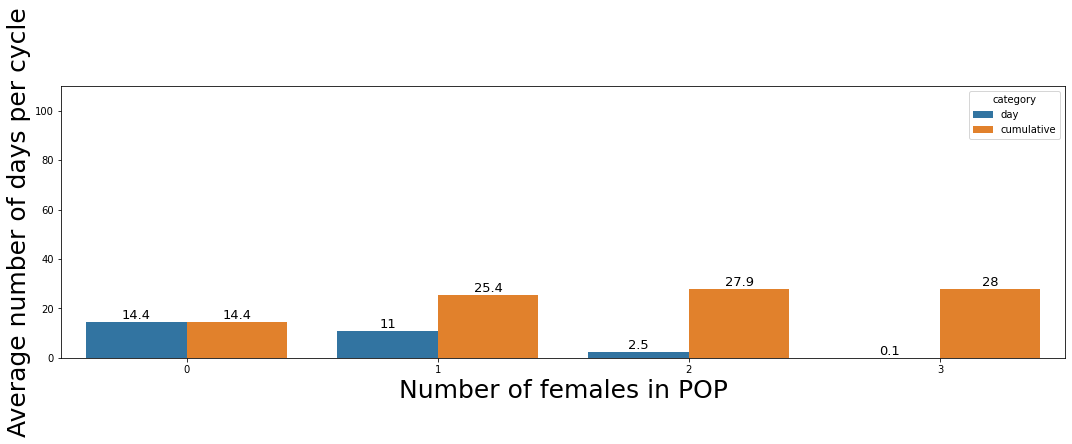

In [59]:
synchronyCharts(model.groups[0])

In [ ]:
modelData = pd.DataFrame([[nMales, nFemales, seasonality, g.modelDays]],
                         columns=['# Males','# Females','Seasonality','Model Days'],
                         index=['Model Data'])

dataM =pd.DataFrame([[m.rank,m.matings,m.reproductiveSuccess,m.cost,m.reproductiveSuccess-m.cost] for m in g.males],
                         columns=['Rank','# of mates','RS', 'Cost', 'RS - Cost'],
                         index=["Male {}".format(i) for i in range(nMales)])

dataF =pd.DataFrame([[f.reproductiveSuccess, f.nonCyclingLength, f.cyclingLength] for f in g.females],
                         columns=['RS','Days Before Cycling','Days Until Conception'],
                         index=["Female {}".format(i) for i in range(nFemales)])
display(modelData)
display(dataM)
display(dataF)
plot([m.reproductiveSuccess-m.cost for m in g.males])